In [228]:
import pandas as pd
import math as math
from datetime import datetime, timedelta 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('./merged-daily-sales.csv')

# Define the list of products you want to keep
items = ['VIU Premium','Netflix Premium','Vidio Premier']

# Filter the dataset
filtered_df = df[df['Produk'].isin(items)]

df = filtered_df.copy()

# Optionally save it to a new file
# df.to_csv('filtered_dataset.csv', index=False)


In [229]:
df = df.sort_values(by=["Tanggal", "Produk"])

# df.to_csv('sorted_dataset.csv', index=False)

Summarized Missing Data : Tanggal    1
Produk     0
Harga      0
dtype: int64
Deleted Data:1


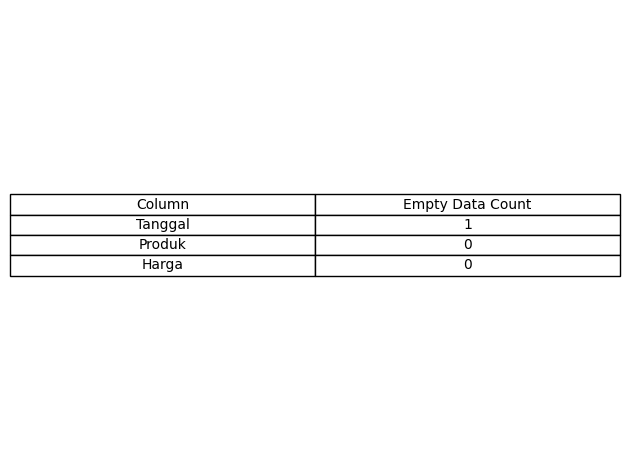

In [230]:
#Check Missing Data
null_data = pd.DataFrame({
    "Column": df.columns,
    "Empty Data Count": df.isnull().sum().values
})
print(f"Summarized Missing Data : {df.isnull().sum()}")


fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


ax.table(cellText=null_data.values, colLabels=null_data.columns, loc='center',cellLoc='center')

fig.tight_layout()

initial_rows = len(df)

df = df.dropna()

# df.to_csv('no_missing_data.csv', index=False)

print(f"Deleted Data:{initial_rows - len(df)}")

In [231]:
df["Tanggal"] = pd.to_datetime(df["Tanggal"], format="%d/%m/%Y")


# Aggregate Data By Sum Per Day

In [232]:
df = df.groupby(['Tanggal', 'Produk']).agg(
    Total_Revenue=('Harga', 'sum'),
    Transaction_Count=('Harga', 'count'),
    Avg_Price=('Harga', 'mean')
).reset_index()

# df.to_csv('grouped_dataset.csv', index=False)

# Remove Outlier Data

In [233]:
z_score = (df['Total_Revenue'] - df['Total_Revenue'].mean()) / df['Total_Revenue'].std()
df['is_outlier'] = (z_score.abs() > 2 ).astype(int)

df = df[df['is_outlier'] == 0].drop(columns=['is_outlier'])

# Add Time Based Features


In [234]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['dayofweek'] = df['Tanggal'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['month'] = df['Tanggal'].dt.month

# Convert to cyclical (recommended)
df['is_month_start'] = df['Tanggal'].dt.is_month_start.astype(int)
df['is_month_end'] = df['Tanggal'].dt.is_month_end.astype(int)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df = df.drop(columns=['dayofweek', 'month'])

# Encode The Produk

In [235]:
# One-hot encode the 'Produk' column
df = pd.get_dummies(df, columns=['Produk'])

df.to_csv('one-hot-encoded.csv', index=False)

In [236]:
products_columns = [col for col in df.columns if col.startswith('Produk_')]
product_id_col = products_columns[0]  # assume first dummy column as identifier temporarily

def calc_slope(series):
    if len(series) < 2:
        return 0
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    return model.coef_[0][0]



In [237]:
df = df.sort_values(by=products_columns + [
      "Tanggal"]).reset_index(drop=True)

# Rolling Mean And Trend and lag Features

In [238]:
enhanced_dfs = []
for prod_col in products_columns:
    prod_df = df[df[prod_col] == 1].copy()
    
    # prod_df['Total_Revenue_smooth'] = prod_df['Total_Revenue'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    # prod_df['revenue_volatility'] = prod_df['Total_Revenue'].transform(lambda x: x.rolling(7).std())
    
    prod_df['smoothed_revenue'] = prod_df['Total_Revenue'].ewm(span=5, adjust=False).mean()
    # Rolling Mean
    prod_df['rolling_mean_7'] = prod_df["Total_Revenue"].rolling(7, min_periods=1).mean()
    prod_df['rolling_mean_14'] = prod_df["Total_Revenue"].rolling(14, min_periods=1).mean()
    prod_df['rolling_mean_30'] = prod_df["Total_Revenue"].rolling(30, min_periods=1).mean()
    
    # Rolling Standard Deviation
    prod_df['rolling_std_7'] = prod_df["Total_Revenue"].rolling(7, min_periods=1).std()
    prod_df['rolling_std_14'] = prod_df["Total_Revenue"].rolling(14, min_periods=1).std()
    prod_df['rolling_std_30'] = prod_df["Total_Revenue"].rolling(30, min_periods=1).std()
        
    # Revenue Trend
    prod_df['revenue_trend_7'] = prod_df["Total_Revenue"].rolling(7).apply(calc_slope, raw=False)
    prod_df['revenue_trend_14'] = prod_df["Total_Revenue"].rolling(14).apply(calc_slope, raw=False)
    prod_df['revenue_trend_30'] = prod_df["Total_Revenue"].rolling(30).apply(calc_slope, raw=False)
    
    #Revenue Lag
    prod_df['revenue_lag_1'] = prod_df['Total_Revenue'].shift(1)
    prod_df['revenue_lag_7'] = prod_df['Total_Revenue'].shift(7)
    prod_df['revenue_lag_14'] = prod_df['Total_Revenue'].shift(14)
    prod_df['revenue_lag_30'] = prod_df['Total_Revenue'].shift(30)

    # Revenue Change
    prod_df['ema_7'] = prod_df['Total_Revenue'].ewm(span=7, adjust=False).mean()
    prod_df['ema_14'] = prod_df['Total_Revenue'].ewm(span=14, adjust=False).mean()
    prod_df['ema_30'] = prod_df['Total_Revenue'].ewm(span=14, adjust=False).mean()
        
    # Price Change lag
    # prod_df['price_change_lag_1'] = prod_df['Avg_Price'].transform(lambda x: x.diff(1))
    # prod_df['price_change_lag_7'] = prod_df['Avg_Price'].transform(lambda x: x.diff(7))
    # prod_df['price_change_lag_14'] = prod_df['Avg_Price'].transform(lambda x: x.diff(14))
    # prod_df['price_change_lag_30'] = prod_df['Avg_Price'].transform(lambda x: x.diff(30))
    
    # Revenue Diff
    
    
    enhanced_dfs.append(prod_df)

# Combine all enhanced product DataFrames
df = pd.concat(enhanced_dfs)

Summarized Missing Data : Tanggal                    0
Total_Revenue              0
Transaction_Count          0
Avg_Price                  0
is_weekend                 0
is_month_start             0
is_month_end               0
dayofweek_sin              0
dayofweek_cos              0
month_sin                  0
month_cos                  0
Produk_Netflix Premium     0
Produk_VIU Premium         0
Produk_Vidio Premier       0
smoothed_revenue           0
rolling_mean_7             0
rolling_mean_14            0
rolling_mean_30            0
rolling_std_7              3
rolling_std_14             3
rolling_std_30             3
revenue_trend_7           18
revenue_trend_14          39
revenue_trend_30          87
revenue_lag_1              3
revenue_lag_7             21
revenue_lag_14            42
revenue_lag_30            90
ema_7                      0
ema_14                     0
ema_30                     0
dtype: int64
Deleted Data:90


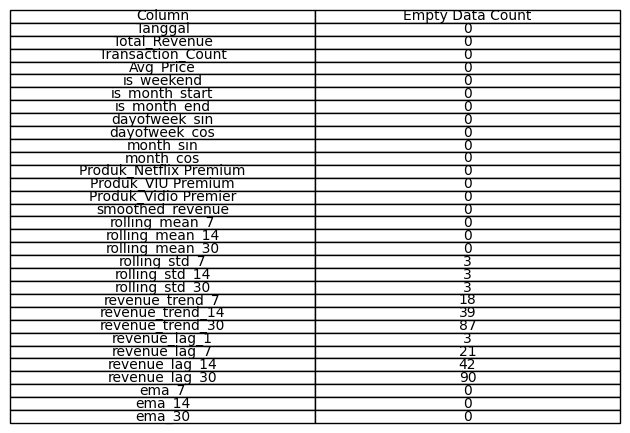

In [239]:
#Check Missing Data
null_data = pd.DataFrame({
    "Column": df.columns,
    "Empty Data Count": df.isnull().sum().values
})
print(f"Summarized Missing Data : {df.isnull().sum()}")


fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


ax.table(cellText=null_data.values, colLabels=null_data.columns, loc='center',cellLoc='center')

# ax.set_title('Jumlah Data Yang Kosong', y=1.0, pad=-70, fontsize=20,fontweight='bold')

fig.tight_layout()

initial_rows = len(df)

df = df.dropna()

# df.to_csv('final_dataset.csv', index=False)

print(f"Deleted Data:{initial_rows - len(df)}")

# Normalize The Data

In [240]:
# normalized_columns =['Total_Revenue', 'Transaction_Count', 'Avg_Price',
#        'weekday_avg', 'rolling_mean_7', 'rolling_mean_14',
#        'rolling_mean_30', 'rolling_std_7', 'rolling_std_14', 'rolling_std_30',
#        'revenue_trend_7', 'revenue_trend_14', 'revenue_trend_30',
#        'revenue_lag_1', 'revenue_lag_7', 'revenue_lag_14', 'revenue_lag_30',
#        'price_change_lag_1', 'price_change_lag_7', 'price_change_lag_14',
#        'price_change_lag_30']

# # scalers = {}
# # scaler = MinMaxScaler()
# # for prod_col in products_columns:
# #     scaler = MinMaxScaler()
# #     mask = df[prod_col] == 1
# #     df.loc[mask, 'Total_Revenue'] = scaler.fit_transform(df.loc[mask, ['Total_Revenue']])
# #     scalers[prod_col] = scaler

# # df.to_csv('normalized_final_dataset.csv', index=False)

# Sort Normalized 

In [241]:
df = df.sort_values(by= products_columns + [
       "Tanggal"]).reset_index(drop=True)

df.to_csv('final_dataset.csv', index=False)

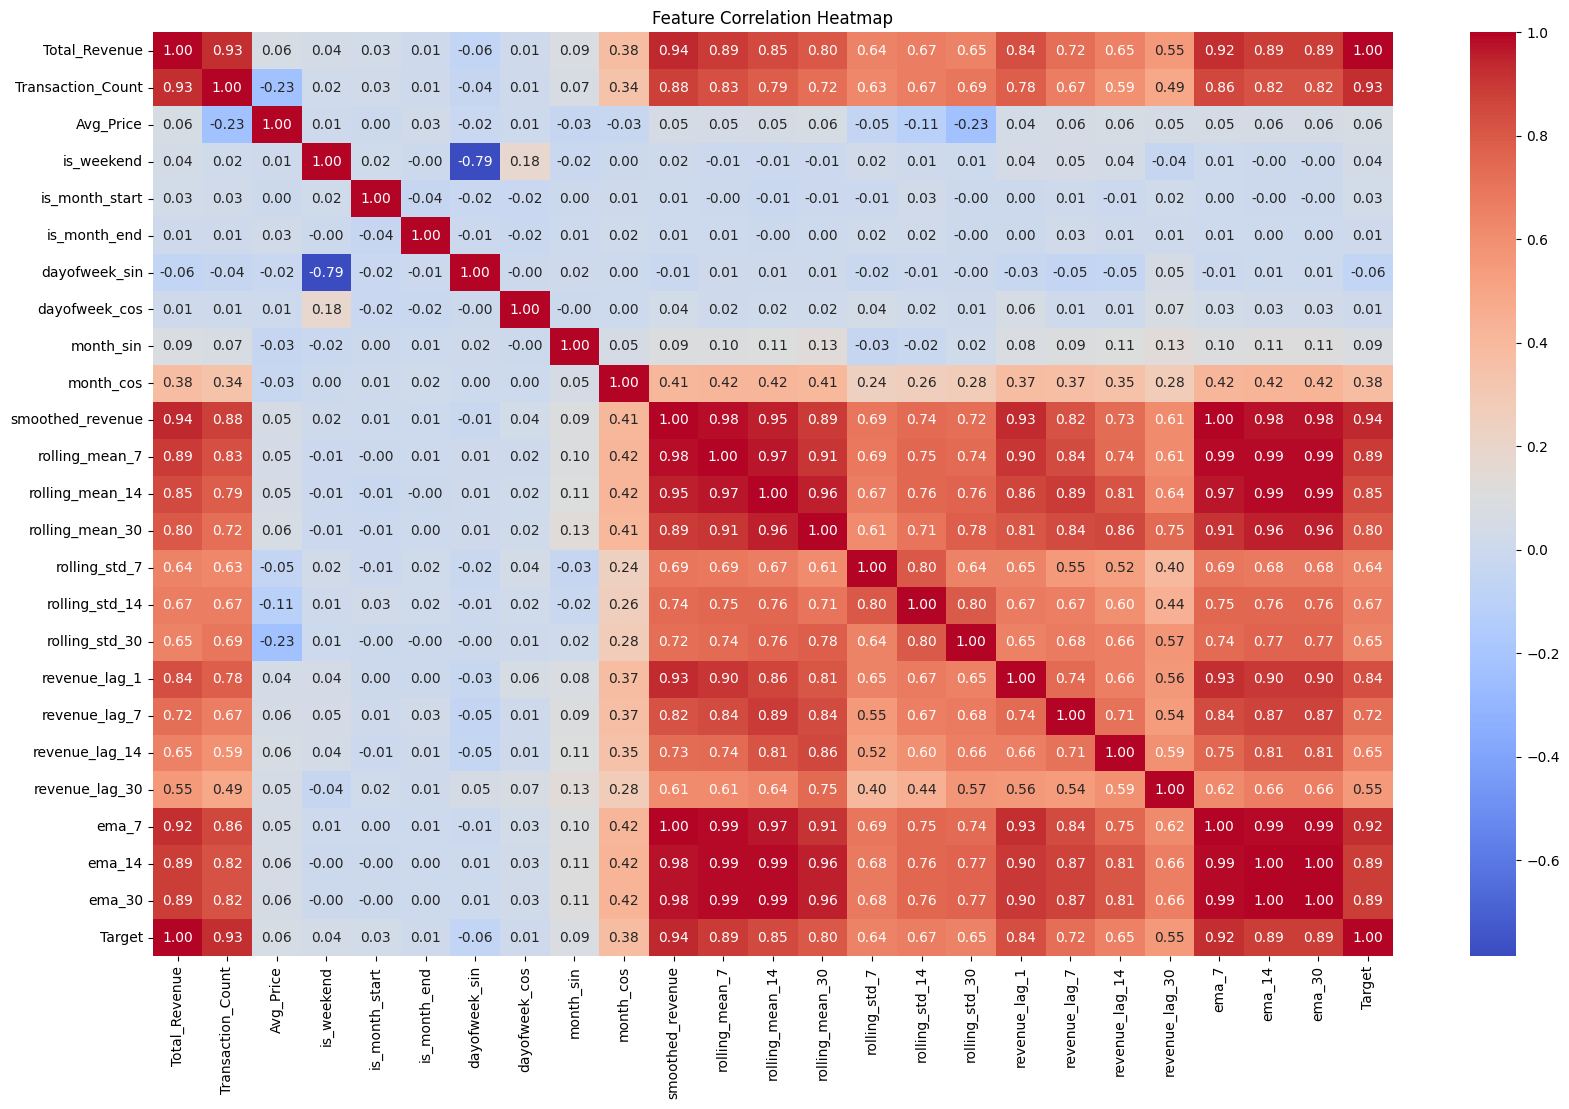

In [242]:
# Check Correlation
# Assume X is a DataFrame of features and y is a Series


features =[
'Total_Revenue', 'Transaction_Count', 'Avg_Price',
  'is_weekend', 'is_month_start', 'is_month_end',
  'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
  'smoothed_revenue', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30',
  'rolling_std_7', 'rolling_std_14', 'rolling_std_30',
  'revenue_lag_1', 'revenue_lag_7', 'revenue_lag_14', 'revenue_lag_30',
  'ema_7', 'ema_14', 'ema_30',
]

df_corr = df[features].copy()
df_corr["Target"] = df["Total_Revenue"]

correlations = df_corr.corr()['Target'].drop('Target')

plt.figure(figsize=(20, 12))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()